# Image alignment
This tutorial shows you how you can use the [Astroalign](https://astroalign.readthedocs.io/en/latest/) to register (align) two stellar astronomical images. Before we begin, you must install the Astroalign package. If you are using the Anaconda distribution of Python (recommended) you can install Astroalign using the [conda-forge Anaconda channel](https://anaconda.org/conda-forge/astroalign), run:
```
conda install -c conda-forge astroalign
```
If you are using a different Python distribution, see the instructions on the [Astroalign Installation page](https://astroalign.readthedocs.io/en/latest/installation.html).

We start by setting `matplotlib` for inline plotting and then importing the needed packages.

In [1]:
# set-up for inline image display
%matplotlib inline

import astroalign as aa
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits

## Load images to align
We will align two images of the artificial star fields called **10 stars**. We will use the two FITS files we will use are `stars06_p.fits` and `stars07_p.fits`. They are both located in the `images` directory. We start by reading the FITS files. 

In [2]:
hdu_list_6 = fits.open('images/stars06_p.fits')
header_6 = hdu_list_6[0].header
image_6 = hdu_list_6[0].data
hdu_list_6.close()

hdu_list_7 = fits.open('images/stars07_p.fits')
header_7 = hdu_list_7[0].header
image_7 = hdu_list_7[0].data
hdu_list_7.close()

Before we proceed, lets make sure the images are of the same `OBJECT` and display the images.

In [3]:
print(header_6['OBJECT'])
print(header_7['OBJECT'])

10 stars
10 stars


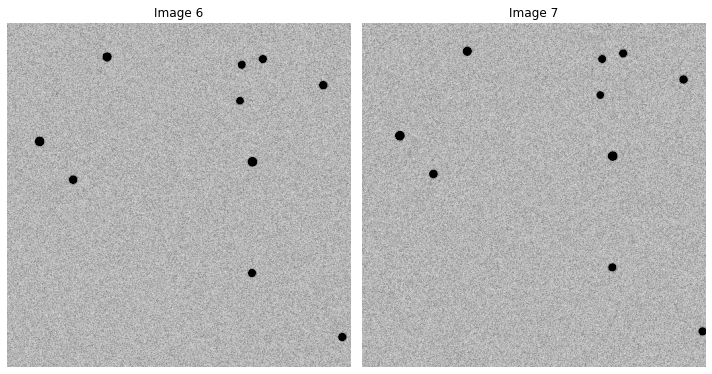

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(image_6, cmap='Greys', vmin=225, vmax=350)
axes[0].axis('off')
axes[0].set_title("Image 6")

axes[1].imshow(image_7, cmap='Greys', vmin=225, vmax=350)
axes[1].axis('off')
axes[1].set_title("Image 7")

plt.tight_layout()
plt.show()

# Find the image transformation
We will use the [`astroalign.find_transform(source,target)`](https://astroalign.readthedocs.io/en/latest/api.html#astroalign.find_transform), where `source` image is to be transformed to the location and orientation of the `target` image. The function returns a [**Similarity Transform**](https://mathworld.wolfram.com/SimilarityTransformation.html) that maps pixel locations from the `source` image into the `target` image locations. The returned transformation can map images that are translated, rotated, and even have slightly different image scaling. 

In [5]:
p, (img_6_srcs, img_7_srcs) = aa.find_transform(image_6, image_7)

The transformation is returned in the `p` object. The two objects `img_6_srcs` and `img_7_srcs` give the coordinates of the sources found by the `astroalign.find_transform()` fucntion.

## Transform the `source` image
Fortunatly, we don't need to know much about the details of the similarity transform `p` to use it to transform the `source` image to the location, rotation, and scale of the `target` image. We apply the transform by using the [`astroalign.apply_transform(p, source, target)`](https://astroalign.readthedocs.io/en/latest/api.html#astroalign.apply_transform) function.

Unfortunatly, in version 2.4 of `astroalign` we have to convert the image data type for our images to floating point numbers (`float`) to make the transform function work properly. We do this using the image method `astype('float')`. 

In [6]:
image_6_aligned, footprint = aa.apply_transform(p, image_6.astype('float'), \
                                                image_7.astype('float'), \
                                                fill_value=1000)

The tranformation takes the first image argument (`image_6` in this case) and shifts it to match the location, rotation, and scale given in the second image argument (`image_7`) and returns a transformed image (`image_6_aligned`) and boolean numpy array called `footprint` in this case. The array `footprint` `True` for masked pixels with no information`footprint` is a boolean numpy array has enties set to `True` for masked pixels with no information. I set the optional `fill_value` keyword argument to 1000 in order to make these maske pixels apparent in `image_6_aligned`. 

Now we will display the original and transfomred images to examine the shift.

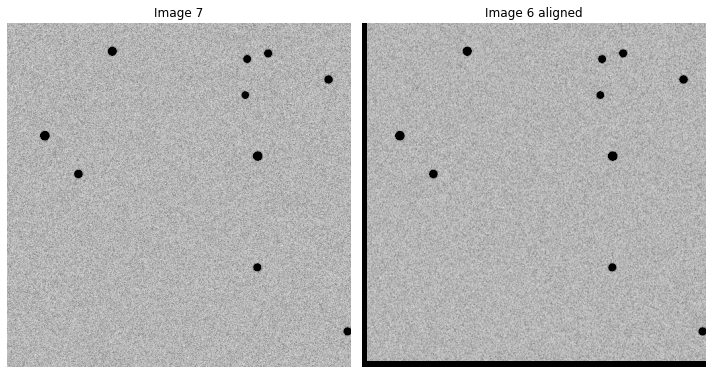

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(image_7, cmap='Greys', vmin=225, vmax=350)
axes[0].axis('off')
axes[0].set_title("Image 7")

axes[1].imshow(image_6_aligned, cmap='Greys', vmin=225, vmax=350)
axes[1].axis('off')
axes[1].set_title("Image 6 aligned")

plt.tight_layout()
plt.show()

It is apparent that the image has been shifted up and to the right to match the locations of the sources in `image_7`. The black boarder on the left and bottom of the transformed image shows where the `fill_value=1000` argument set the pixel values to 1000. 

## Write the shifted image to a new FITS file
We will start by creating a new header for the file. We'll do this by making a copy of `header_6` and then adding a new keyword `ALINGED` to the file that specifies how the image was aligned.  

In [8]:
header_6_aligned=header_6
header_6_aligned['ALINGED'] = 'Aligned to stars07_p.fits'
header_6_aligned

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
EXTEND  =                    T                                                  
OBJECT  = '10 stars'                                                            
EXPTIME =                   60                                                  
GAIN    =                  2.6                                                  
ALINGED = 'Aligned to stars07_p.fits'                                           

We now create a new FITS file with the shifted image and the new header.

In [9]:
fits.writeto('images/stars06_aligned_example.fits',image_6_aligned,header_6_aligned,
             overwrite=True)

## Image arithmetic on aligned images
We typically need to align images when we need to some further processing. For example, we might want to add several images togther to improve the signal-to-noise ratio, or subtract one image from another the images to look for brightness changes in some source. 

Let's subtract `image_6_aligned` from `image_7` to see if there was a brigtness change of any sources. The difference will also show if there have been any in errors in the image alignment. We'll use [`astropy.stats.sigma_clipped_stats()`](https://docs.astropy.org/en/stable/api/astropy.stats.sigma_clipped_stats.html) to get the mean, median, and standard deviation of the sigma-clipped image data in order to set the scaling for displaying the image.

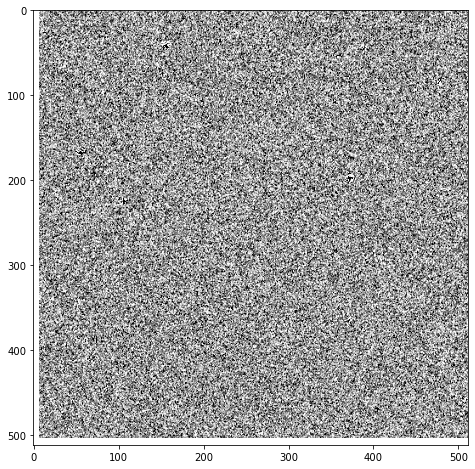

In [10]:
img_diff = image_7 - image_6_aligned

from astropy import stats
(median,mean,stdev) = stats.sigma_clipped_stats(img_diff, sigma=2, maxiters=5)

fig,axes = plt.subplots(1, 1,figsize=(8, 8))
axes.imshow(img_diff, cmap='Greys', vmin=median-2*stdev, vmax=median+2*stdev)
plt.show()

It looks like there was not brigtness changes in any of the sources. The white bottom and left edges of the images are the regions in `image_6_aligned` where `fill_value=1000`.  

## Summary
We've used [`astroalign`](https://astroalign.readthedocs.io/en/latest/) package to shift one image (`stars06_p.fits`) in order to align it with `stars07_p.fits`. We wrote the shifted image to a new FITS file (`stars06_aligned_example.fits`). Full documentation for `astroalign` is available at https://astroalign.readthedocs.io/. You can find another Jupyter notebook that explores more features of `astroalign` at http://quatrope.github.io/astroalign. You can also download the script `image_alignment.py` from the `code` directory to use as a starting point for writing your own image alignment programs.